In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk
from collections import Counter

/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
#tokenization resources
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
from nltk.corpus import words
nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johndriscoll/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/johndriscoll/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
#for NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


In [147]:
#for coherence implementation
from gensim.models import Word2Vec
from itertools import combinations
from operator import itemgetter

### Data Cleaning & EDA

Our dataset is a collection of 18,000 newsgroup documents from 20 different newgroups. The dataset has been split into training and testing subsets. We will be training our topic model on the larger subset, the training set. Since our algorithm is an unsupervised machine learning algorithm, we will not be using the test set. Additionally, the target values for the 20 different newsgroups will be used to assess the evaluation of our model in correctly extracting relevant topics.

In [3]:
# import dataset from sklearn and remove headers and footers for a more realistic model

from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset='train', remove=['headers', 'footers'])

Past research on this dataset has shown a tendency for topic models to overfit on headers, so we have removed them from the data. This will improve generalizability to other documents that do not follow the same format.

The data is split into document contents and targets. The 20 newsgroup targets are show below.

In [4]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

An example of a document and its corresponding newsgroup is illustrated. _Data_ includes the content of the newsgroup document, _target_ includes the index of the category of the newsgroup, and _target_names_ includes the name of the category of the newsgroup.

In [5]:
dataset.data[3]

"Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice.  It's got this\n> quadrilateral fill command that requires just the four points.\n\nDo you have Weitek's address/phone number?  I'd like to get some information\nabout this chip.\n"

In [6]:
dataset.target[3], dataset.target_names[dataset.target[3]]

(1, 'comp.graphics')

We can represent this data as a dataframe for more efficient data cleaning and data exploration.

In [7]:
newsgroup_df = pd.DataFrame({"document": dataset.data, "target": dataset.target})
newsgroup_df = newsgroup_df.assign(newsgroup=newsgroup_df["target"].apply(lambda x: dataset.target_names[x]))
newsgroup_df.head()

,document,target,newsgroup
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


Let's do some exploratory data analysis to better understand our dataset. First, we can look at the distriubtion of our newsgroup targets to see if there are any outliers.

/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Number of Corresponding Documents')

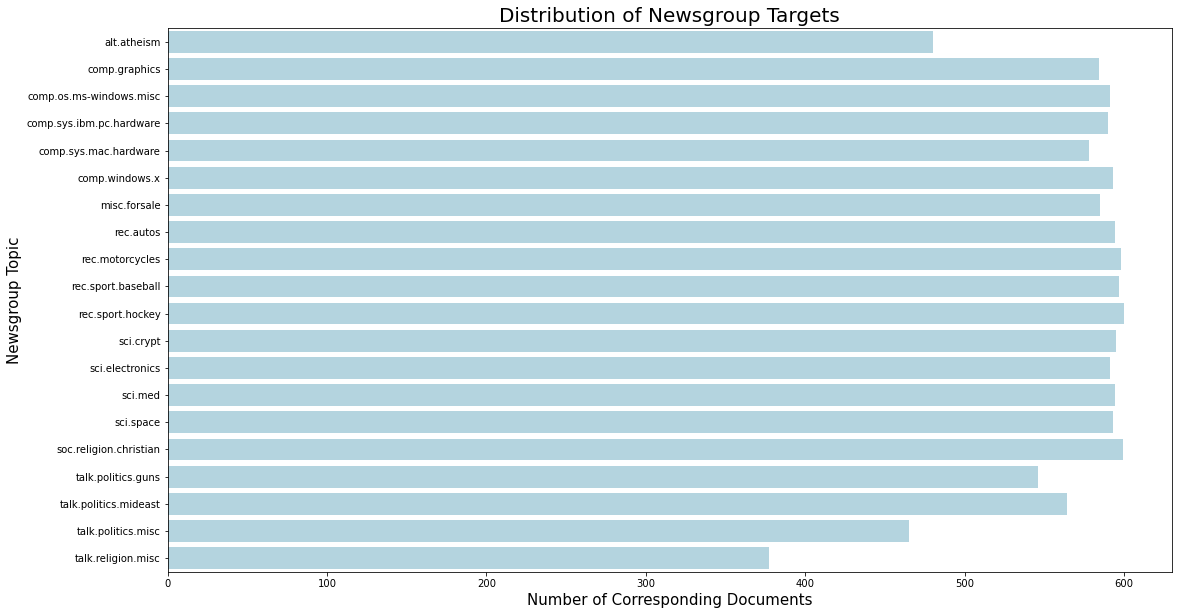

In [8]:
# plot the distribution of the newsgroups
fig1 = plt.figure(figsize =[18 ,10])
ax = sns.countplot(y=newsgroup_df['newsgroup'], color="lightblue", order=dataset.target_names)
plt.title('Distribution of Newsgroup Targets', size=20)
plt.ylabel('Newsgroup Topic', size = 15)
plt.xlabel('Number of Corresponding Documents', size = 15)

Talk.politics.misc and talk.religion.misc are more abstract, overlap with other topics like talk.politics.guns and alt.atheism, and have lower counts of associated documents. We will remove them from our training set and focus on the remaining 18 topics instead.

In [9]:
newsgroup_df = newsgroup_df[(newsgroup_df["newsgroup"] != 'talk.politics.misc') & (newsgroup_df["newsgroup"] != 'talk.religion.misc')]
newsgroup_df.shape

(10472, 3)

In [10]:
newsgroup_df["document"]

0        I was wondering if anyone out there could enli...
1        A fair number of brave souls who upgraded thei...
2        well folks, my mac plus finally gave up the gh...
3        Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...
4        From article <C5owCB.n3p@world.std.com>, by to...
                               ...                        
11309    DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
11310    I have a (very old) Mac 512k and a Mac Plus, b...
11311    I just installed a DX2-66 CPU in a clone mothe...
11312    In article <1qkgbuINNs9n@shelley.u.washington....
11313    Stolen from Pasadena between 4:30 and 6:30 pm ...
Name: document, Length: 10472, dtype: object

In [11]:
words_per_document = newsgroup_df["document"].apply(lambda x: len(x.split(" ")))
mean_words = words_per_document.mean()
std_words = words_per_document.std()
print("mean number of words:", mean_words, "standard deviation of number of words:", std_words)

mean number of words: 257.52320473644005 standard deviation of number of words: 645.7135193230087


In [128]:
#total number of distinct words
sum(words_per_document.unique())

1189673

In [12]:
newsgroup_df["document"].apply(lambda x: len(x.split(" "))).value_counts().sort_values()[:300]

document
714      1
823      1
789      1
1138     1
3953     1
        ..
625      1
725      1
4869     1
10554    1
631      1
Name: count, Length: 300, dtype: int64

In [13]:
print('max words per document', max(words_per_document), ', min words per document', min(words_per_document))

max words per document 20083 , min words per document 1


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9915703fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9915719670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9915703b80>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9915719d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9915725160>],
 'means': []}

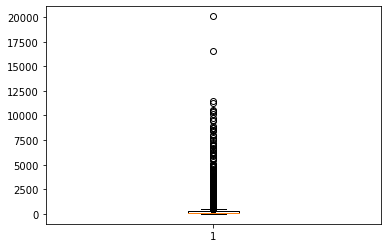

In [14]:
plt.boxplot(words_per_document)

We can now preprocess the data for the topic model. We will first clean the documents by removing punctation, numbers, and characters, converting to lowercase, and stripping empty strings. We will also remove non-descriptive words such as "a", "is", "from", "and", etc. We will add additional stop words that occur often in our dataset but do not have any significant meaning for the theme extraction. Lastly, we will lemmatize our documents, meaning we will distill words into their foundational terms, like "running" to "run". This will help reduce unnecessary and redundant terms and ensure a faster runtime.

In [15]:
# List of stop words
additional_stop_words = set(["article", "subject", 'time','im','thing', 'new', 'said', 'need', 'want', 'did',
                             'know','like','people','think','writes','just','dont', '___', 'good', 'used',
                            "use", "think", 'doe', "year", "say", "make", 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax'])
stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)

# Splits words on white spaces
def tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def process_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation, numbers, \n, and extra whitespaces
    text = re.sub(r'\d+|[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'\s{2,}', ' ', text)
    # only include english dictionary words
    # Tokenize and lemmatize
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(word) for word in tokenizer(text) if word not in stop_words]
    text = [each for each in tokens if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return " ".join(text)

In [16]:
# Set options to display all rows and columns
newsgroup_df['document'][1]

"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks."

In [17]:
newsgroup_df['document'][:10].apply(process_text)

0    wondering enlighten car saw day door sport car...
1    fair number brave soul upgraded si clock oscil...
2    folk mac plus finally gave ghost weekend start...
3    robert jc kyanko robrjckuucp wrote abraxisiast...
4    cowcbnpworldstdcom tombakerworldstdcom tom bak...
5    reuttransferstratuscom cdtswstratuscom tavares...
6    responded request info treatment astrocytomas ...
7    dxbpsuvmpsuedu qlbrlinnrkdnsnmsuedu bgrubbdant...
8    win downloaded icon bmps figure change wallpap...
9    jappocwruedu joseph pellettiere looking inform...
Name: document, dtype: object

In [18]:
### tokenize the abstracts
newsgroup_df['processed_documents'] = newsgroup_df['document'].apply(process_text)
newsgroup_df['processed_documents']

0        wondering enlighten car saw day door sport car...
1        fair number brave soul upgraded si clock oscil...
2        folk mac plus finally gave ghost weekend start...
3        robert jc kyanko robrjckuucp wrote abraxisiast...
4        cowcbnpworldstdcom tombakerworldstdcom tom bak...
                               ...                        
11309    dn nyedacnsvaxuwecedu david nye dn neurology d...
11310    old mac mac plus problem screen blank minor ph...
11311    installed dx cpu clone motherboard tried mount...
11312    qkgbuinnsnshelleyuwashingtonedu bolsoncarsonuw...
11313    stolen pasadena pm blue white honda cbrrr cali...
Name: processed_documents, Length: 10472, dtype: object

In [19]:
# Get the top 20 most common words among all the documents

p_text = ' '.join(newsgroup_df['processed_documents'].tolist())

p_text = p_text.split(' ')

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,doe,3508
1,file,2821
2,right,2809
3,problem,2806
4,way,2586
5,work,2475
6,window,2402
7,god,2307
8,question,2042
9,program,1952


In [20]:
top_20['word'][15]

'game'

### NMF - Manual Topic Number

Transform lemmatized and cleaned words into a document-term frequency matrix (DTM)

In [149]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)

# Fit and transform the processed abstracts into DTM
dtm = vectorizer.fit_transform(newsgroup_df['processed_documents'])

In [150]:
def do_nmf(n_topics):

    # Specify the number of topics
    nmf_model = NMF(n_components=n_topics)
    W = nmf_model.fit_transform(dtm)  # Document-topic matrix   (n_samples, n_components)
    H = nmf_model.components_         # Topic-term matrix       (n_components, n_features)
    return W, H

In [151]:
n_topics = 18
W, H = do_nmf(n_topics)

/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [139]:
feature_names = vectorizer.get_feature_names_out()
for index, topic in enumerate(H):
    print(f"Topic #{index + 1}:")
    print(",".join([feature_names[i] for i in topic.argsort()[-10:]]))  # Top 10 words per topic

Topic #1:
thing,food,question,group,really,day,way,ive,msg,problem
Topic #2:
running,version,using,problem,font,manager,program,application,do,window
Topic #3:
hd,cable,switch,jumper,problem,boot,hard,floppy,disk,drive
Topic #4:
fan,league,baseball,hockey,season,win,play,player,team,game
Topic #5:
secure,algorithm,bit,phone,government,escrow,clipper,encryption,chip,key
Topic #6:
church,truth,belief,atheist,believe,faith,bible,jesus,christian,god
Topic #7:
manual,sell,asking,modem,printer,condition,shipping,price,sale,offer
Topic #8:
bus,vesa,vga,graphic,mode,ati,diamond,video,driver,card
Topic #9:
help,information,address,doe,info,looking,hi,advance,email,thanks
Topic #10:
policy,state,lebanon,peace,lebanese,palestinian,jew,arab,israeli,israel
Topic #11:
convert,gif,disk,bmp,ftp,image,directory,format,program,file
Topic #12:
government,handgun,state,crime,criminal,right,firearm,law,weapon,gun
Topic #13:
azerbaijan,azeri,muslim,greek,genocide,turk,turkey,armenia,turkish,armenian
Topic #

In [140]:
# Let's say we want the topic distribution for the first document (index 0)
document_index = 10
document_topics = W[document_index]  # Get topic weights for this document

# Identify the dominant topic for this document
dominant_topic = np.argmax(document_topics)

print(f"Document #{document_index + 1} dominant topic: Topic {dominant_topic + 1}")
print(f"Topic Distribution for Document #{document_index + 1}:")
for topic_idx, weight in enumerate(document_topics):
    print(f"Topic {topic_idx + 1}: {weight:.4f}")

# Print the top words for the dominant topic to understand its meaning
top_word_indices = H[dominant_topic].argsort()[-10:]  # Top 10 words for the dominant topic
print(f"\nTop words for Dominant Topic {dominant_topic + 1}:")
print(" ".join([feature_names[i] for i in top_word_indices]))
print(newsgroup_df.iloc[document_index]["newsgroup"])
print(newsgroup_df.iloc[document_index]["document"])

Document #11 dominant topic: Topic 17
Topic Distribution for Document #11:
Topic 1: 0.0000
Topic 2: 0.0000
Topic 3: 0.0023
Topic 4: 0.0000
Topic 5: 0.0000
Topic 6: 0.0000
Topic 7: 0.0025
Topic 8: 0.0000
Topic 9: 0.0245
Topic 10: 0.0000
Topic 11: 0.0000
Topic 12: 0.0000
Topic 13: 0.0000
Topic 14: 0.0004
Topic 15: 0.0115
Topic 16: 0.0000
Topic 17: 0.1223
Topic 18: 0.0100

Top words for Dominant Topic 17:
mile honda dod helmet dog riding rider ride motorcycle bike
rec.motorcycles
I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
----------------------------------------

#### Residual Score (NMF only)

"Residuals are differences between the observed and predicted values of the data. A residual of 0 means the topic perfectly approximates the text of the article, so the lower the better.

To calculate the residual you can take the Frobenius norm (square root of the sum of the absolute squares of its elements) of the tf-idf weights (A) minus the dot product of the coefficients of the topics (H) and the topics (W). We can then get the average residual for each topic to see which has the smallest residual on average." - https://freedium.cfd/https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45 
<br><br><br>
How well do the topics approximate the original weights of the tfidf matrix for each document?
Averaged across topics, can get the sense of how good of an approximator each topic is.

Residual$[x_i]$$\norm{x_i - W_i \dot H}_F$ where document $x_i \in$ documents $X$, $W_i$ is row i of the Document-topic matrix and $H$ is the Topic-term matrix    

In [162]:
# For each document calculate the difference between the original tfidf weights and those predicted
# by multiplying W and H for that specific row.
# Cell Source: https://freedium.cfd/https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
def do_residual(dtm, W, H):
    residuals = np.zeros(dtm.shape[0])
    for row in range(dtm.shape[0]):
        # 'fro' here means we are using the Frobenium norm as the distance metric
        residuals[row] = np.linalg.norm(dtm[row, :] - W[row, :].dot(H), 'fro')
    return residuals

residuals = do_residual(dtm, W, H)
residuals

array([0.86997882, 0.98167667, 0.95914379, ..., 0.99333907, 0.98706183,
       0.99290276])

In [178]:
np.mean(residuals)

0.970847744962895

Text(0.5, 1.0, 'Average Residual per Document by Main Topic')

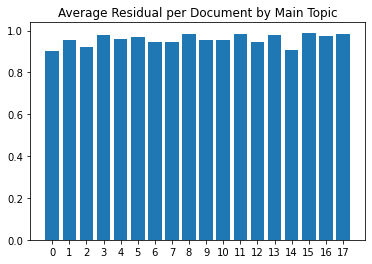

In [163]:
residuals_by_topic = pd.Series(residuals).groupby(np.argmax(W, axis=1)).mean()
plt.bar(x=residuals_by_topic.index, height=residuals_by_topic.values)
plt.xticks(residuals_by_topic.index)
plt.title("Average Residual per Document by Main Topic")

Residuals are nearly indistinguishable by visualization.

In [164]:
residuals_by_topic.sort_values(ascending=False)

15    0.990003
8     0.984839
17    0.983752
11    0.981852
3     0.981042
13    0.979894
16    0.973994
5     0.970253
4     0.958097
10    0.954919
9     0.953967
1     0.953938
6     0.947169
7     0.946123
12    0.943851
2     0.921431
14    0.908278
0     0.904748
dtype: float64

Topic 1 has the lowest residual while topic 2 has the highest. 

#### "Expert" Manual Evaluation

Since relevance is difficult to interpret without a baseline, we compare the two for quality below by inspecting sets of training instances.

In [93]:
chosen_topic_1 = np.random.choice(np.array(range(dtm.shape[0]))[np.argmax(W, axis=1)==1], size=5, replace=False)
display([feature_names[i] for i in H[1].argsort()[-10:]])
for i, content in newsgroup_df['document'].iloc[chosen_topic_1].items(): display((i, content))
chosen_topic_2 = np.random.choice(np.array(range(dtm.shape[0]))[np.argmax(W, axis=1)==2], size=5, replace=False)
display([feature_names[i] for i in H[2].argsort()[-10:]])
for i, content in newsgroup_df['document'].iloc[chosen_topic_2].items(): display((i, content))

['machine',
 'display',
 'line',
 'image',
 'program',
 'screen',
 'color',
 'using',
 'server',
 'problem']

(964,
 "I have a problem where an Athena strip chart widget is not calling it's\nget value function.  I am pretty sure this is happening because I am\nnot using XtAppMainLoop, but am dealing with events via sockets.  (ya ya).\n\nAnyway, I want to cause a timeout so that the strip chart widget(s) will\ncall their get value callback.  Or if someone knows another FAST way around\nthis (or any way for that matter) let me know.  I cannot (or I don't think)\ncall the XtNgetValue callback myself because I don't have the value for\nthe third parameter of the get value proc (XtPointer call_data).  \n\nIn other words, I want to force a strip chart widget to update itself.\n\nAny ideas anyone?  \n")

(8231,
 'I would be interested in hearing from anyone who knows of good software for\nantenna simulation, particularly in source form suitable for Unix workstations\n(though good PC software would also be of interest).\nI\'m aware of the numerous mininec mutations, and have been using MN for\nsome time now.  I\'m primarily interested in HF, VHF, and low UHF (< 500 MHz)\ndesigns, mostly wire antennas, but for thick wires and mesh surfaces as well\nas for your basic thin wire assumption.\nIs anything interesting happening with NEC itself?  I\'ve seen a version\nthat was mutilated to run (sort of) under Microsoft Fortran, but I\'m not\nsure how many "new and improved" versions of the code might be out there\nsomewhere.\nI\'d also be interested in non-NEC derivatives.  The ones I\'ve seen have\nbeen aimed at microwave applications, but if there is something out there\nuseful at the lower frequencies, I\'d like to know about it.\nThanks,')

(4181,
 ": Robert G. Carpenter writes:\n\n: >Hi Netters,\n: >\n: >I'm building a CAD package and need a 3D graphics library that can handle\n: >some rudimentry tasks, such as hidden line removal, shading, animation, etc.\n: >\n: >Can you please offer some recommendations?\n: >\n: >I'll also need contact info (name, address, email...) if you can find it.\n: >\n: >Thanks\n: >\n: >(Please Post Your Responses, in case others have same need)\n: >\n: >Bob Carpenter\n: >\n\nThe following is extracted from sumex-aim.stanford.edu.  It should also be on\nthe mirrors.  I think there is source for some applications that may have some\nbearing on your project.  Poke around the source directory.  I've never used\nthis package, nor do I know anyone who did, but the price is right :-)\n\nHope this helps.\n\n\t\t\t\t\tCheinan\n\nAbstracts of files as of Thu Apr  1 03:11:39 PST 1993\nDirectory: info-mac/source\n\n#### BINHEX     3d-grafsys-121.hqx   ****\n\nDate: Fri, 5 Mar 93 14:13:07 +0100\nFrom: Chri

(1622,
 "In article <1993Apr2.203400.15357@kocrsv01.delcoelect.com> c2xjfa@kocrsv01.delcoelect.com (James F Allman III) writes:\n>\n>> \n>> > I'm doing a study on what the following type of users would like to\n>> > have on a Unix Manager.  Basically I'm looking for the Unix commands\n>> > and features on Motif window interface which will help the different\n>> > type of users make use of Unix.\n>> ...\n\n\n>> Personally, I can't stand Motif.  I also can't stand GUI      Command Line!\n>> interfaces for things like access to the commands I know      Command Line!\n>> and love.  I think you'll find that experience [sic] users    Command Line!\n>> \n>> \t\t\t\t\tder Mouse\n>> ...\n\n\n>A year and a half ago I felt the same way.  The I started using\n>gooyies.  Give me the command line when something out of the ordinary\n>needs done, and the gooy when I am doing normal or repative work. \n>Note that most operations are repetative.  Hackers love CLs because\n>  ...\n\nWhat I like about GUI

(2098,
 'Hi,\n\n  I am trying to write an X-windows based interface that runs on top of GDB. Could \nanyone help me in understanding the way we are supposed to "fork" GDB off as a \nsubprocess ?? I currently use pipes but when I try and debug this program, the \nfollowing happens :\n\nPROGRAM :\n\n\tmain()\n\t{\n           int x;\n \n\n\t   printf("enter x : ");\n           scanf("%d", &x);\n           printf("x = .%d.\\n", x );\n\n        }\n\nOUTPUT :\n\n\tThe program hangs without returning the output of the printf statement. When I type\nin a value (like 5), then all the printf\'s output comes out at one time.\n\n\nIs there any other way, besides using PIPES to do this i.e., like ioctl or something else ??\n\nThanks,\n\nDeepak\n')

['controller',
 'switch',
 'cable',
 'jumper',
 'problem',
 'boot',
 'hard',
 'floppy',
 'disk',
 'drive']

(5955,
 "I haven't seen much info about how to add an extra internal disk to a\nmac. We would like to try it, and I wonder if someone had some good\nadvice.\n\nWe have a Mac IIcx with the original internal Quantum 40MB hard disk,\nand an unusable floppy drive. We also have a new spare Connor 40MB\ndisk which we would like to use. The idea is to replace the broken\nfloppy drive with the new hard disk, but there seems to be some\nproblems:\n\nThe internal SCSI cable and power cable inside the cx has only\nconnectors for one single hard disk drive.\n\nIf I made a ribbon cable and a power cable with three connectors each\n(1 for motherboard, 1 for each of the 2 disks), would it work?\n\nIs the IIcx able to supply the extra power to the extra disk?\n\nWhat about terminators? I suppose that i should remove the resistor\npacks from the disk that is closest to the motherboard, but leave them\ninstalled in the other disk.\n\nThe SCSI ID jumpers should also be changed so that the new disk gets\n

(1639,
 "In article <1quod6$i3n@menudo.uh.edu>, sunnyt@coding.bchs.uh.edu wrote:\n> \n> In article <1993Apr19.164734.24779@newsgate.sps.mot.com>  \n> rjacks@austlcm.sps.mot.com (rodney jacks) writes:\n> > I would really like to get one of the new CD300i CDROM\n> > drives for my c650, but my local Apple doesn't know \n> > when they will be available.  He doesn't even have a part\n> > number yet.   Does anyone know what the part number \n> > for this drive is and when it will be available?\n> > \n> > My Apple dealer suggested I buy one of the CD300 external\n> > drives, but I don't want to pay extra for a case/power supply\n> > I'm not going to use.\n> > \n> > -Rodney Jacks\n> > (rjacks@austlcm.sps.mot.com)\n> \n\t\t\t  While there may not be a part number for the CD300i drive, I have seen\na part number for the bezel kit (a new front panel with the slot in it\nthrough which you insert the CD). The document (which I got from the\n2/10/93 announcement at our Apple office) states the drive

(3017, 'WHAT IS THE FLANK DRIVE EVERYONES TALKING ABOUT?\n')

(7363,
 '2-gigabyte Fujitsu 5.25" disk drive\ninternal drive, model M26525A\n(uses either a SCSI or EDI interface on your disk controller card)\nbrand new, still in box, never used\n\n  only $1800 (compare to $2400 in cheapest mail-order catalogs)')

(511,
 'In article <9304172194@jester.GUN.de>, michael@jester.GUN.de (Michael Gerhards) writes:\n> Holly       KS (cs3sd3ae@maccs.mcmaster.ca) wrote:\n>> My Western Digital also has three sets of pins on the back. I am using it with\n>> another hard drive as well and the settings for the jumpers were written right \n>> on the circuit board of the WD drive......MA SL ??\n> \n> The ??-jumper is used, if the other drive a conner cp3xxx. \n> \n> no jumper set: drive is alone\n> MA: drive is master\n> SL: drive is slave\n\nyo,yo,yo .\nthe western digital hd will hve it marked either s,m,a\nput jumper on the s "its printed on the circuitry underkneth it.\n\nhope i helped i had the same problem.\nbye..\nlater daze.\noharad@wanda.waiariki.ac.nz\n')

Both topics seem to be representative of the randomly chosen instances best explained by that topic.

#### Coherence Score for NMF

Coherence score measures the relative distance between words within a topic.

##### TC-W2V Implementation for SKLearn 
Source: https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

<b>Build a Word Embedding</b>

To select the number of topics, here we will use a topic coherence measure called TC-W2V. This measure relies on the use of a word embedding model constructed from our corpus. So in this step we will use the Gensim implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

In [94]:
#First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [ ]:
# # Now build a Skipgram Word2Vec model from all documents in the input file using Gensim:

# raw_documents = newsgroup_df['processed_documents']
# custom_stop_words = stop_words

# docgen = TokenGenerator(raw_documents, custom_stop_words)
# # the model has 500 dimensions, the minimum document-term frequency is 20
# w2v_model = Word2Vec(docgen, vector_size=500, min_count=20, sg=1)

# # Save for later use, so that we do not need to rebuild it:
# # w2v_model.save("w2v-model.bin")

# print("Model has %d terms" % len(w2v_model.wv.key_to_index))

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Model has 6997 terms


In [132]:
# To re-load this model, run
w2v_model = Word2Vec.load("w2v-model.bin")

<b>Selecting the Number of Topics</b>

Once we have our Word2vec model, we can use it as part of our topic coherence approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.


In [133]:
# We use the Word2vec model to calculate coherence scores for each of these models. 
# We will define this coherence score as follows:

def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            try: # sometimes a term NMF identified may not have been identified by w2v
                pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
            except:
                None
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

#We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [144]:
def do_coherence(k, W, H, terms=feature_names):
    """Generates a final coherence score for a NMF model"""
    # where k is number of topics

    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    global temp_top_terms
    temp_top_terms = term_rankings
    curr_coherence = calculate_coherence( w2v_model, term_rankings )
    print("K=%02d: Coherence=%.4f" % ( k, curr_coherence ) )
    return curr_coherence

In [145]:
do_coherence(18, W, H)

K=18: Coherence=0.4881


0.4881122863518052

end sourced code

### NMF - Automatic Topic Number

In practice, a model will not know a-priori the true number of topics in a set, so coherence score can be used as a measure to choose the best topic model across multiple numbers of topics.

In [ ]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(10, 30, 2))
coherence_scores = dict()
nmf_models = dict()

for k in topic_nums:
    curr_W, curr_H = do_nmf(k)
    nmf_models[k] = (curr_W, curr_H)
    coherence_scores[k] = do_coherence(k, curr_W, curr_H)

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums.values(), coherence_scores.values()))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics, coherence_scores[best_num_topics])

K=10: Coherence=0.4485
K=12: Coherence=0.4756


/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


K=14: Coherence=0.4794


/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


K=16: Coherence=0.4859


/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


K=18: Coherence=0.4903


/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


K=20: Coherence=0.5160
K=22: Coherence=0.5215
K=24: Coherence=0.5140
K=26: Coherence=0.5224
K=28: Coherence=0.5321
28


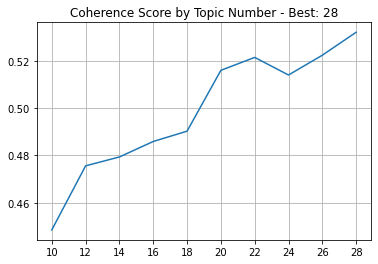

In [169]:
plt.plot(topic_nums, coherence_scores)
plt.title("Coherence Score by Topic Number - Best: {}".format(best_num_topics))
plt.grid(True)
plt.xticks(topic_nums)
plt.show()

In [179]:
# manually selected had residual of 0.98
np.mean(do_residual(dtm, nmf_models[-1][0], nmf_models[-1][1]))

0.9636908113434091

The matrix chosen by coherence score had a worse residual than the one chosen with 18 features, indicating that selecting by coherence score may not result in the best decomposition, but it is standard practice at the moment.

### Run NMF